In [1]:
#!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 2.8 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 2.5 MB/s eta 0:00:0000:0100:02


## Load required packages

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Loading and Data preparation

In [29]:
balanced_data = pd.read_csv("../../data/balanced_data.csv")

In [30]:
balanced_data.head()

is_canceled  lead_time  stays_in_weekend_nights  stays_in_week_nights  \
0            0         62                        1                     4   
1            0        147                        1                     3   
2            0         11                        0                     2   
3            0        190                        2                     1   
4            0        101                        1                     4   

   adults  children  babies meal market_segment distribution_channel  ...  \
0       1         0       0   BB      Online TA                TA/TO  ...   
1       2         0       0   BB      Online TA                TA/TO  ...   
2       2         0       0   BB      Online TA                TA/TO  ...   
3       2         0       0   BB      Online TA                TA/TO  ...   
4       2         0       0   BB  Offline TA/TO                TA/TO  ...   

   booking_changes  deposit_type  days_in_waiting_list  customer_type     adr  \
0                1    No Deposit                     0      Transient   45.00   
1                0    No Deposit                     0      Transient  105.68   
2                0    No Deposit                     0      Transient   80.30   
3                0    No Deposit                     0      Transient  105.30   
4                0    No Deposit                     0      Transient   59.60   

   required_car_parking_spaces total_of_special_requests  used_company  \
0                            1                         1             0   
1                            0                         1             0   
2                            0                         1             0   
3                            1                         1             0   
4                            0                         0             0   

   used_agent  reserved_is_assigned  
0           1                     1  
1           1                     1  
2           1                     1  
3           1                     1  
4           1                     1  

[5 rows x 23 columns]

In [31]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47942 entries, 0 to 47941
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     47942 non-null  int64  
 1   lead_time                       47942 non-null  int64  
 2   stays_in_weekend_nights         47942 non-null  int64  
 3   stays_in_week_nights            47942 non-null  int64  
 4   adults                          47942 non-null  int64  
 5   children                        47942 non-null  int64  
 6   babies                          47942 non-null  int64  
 7   meal                            47942 non-null  object 
 8   market_segment                  47942 non-null  object 
 9   distribution_channel            47942 non-null  object 
 10  is_repeated_guest               47942 non-null  int64  
 11  previous_cancellations          47942 non-null  int64  
 12  previous_bookings_not_canceled  

In [32]:
# Drop unwanted columns
df = balanced_data.drop(["stays_in_weekend_nights", "babies", "meal",
                         "distribution_channel", "is_repeated_guest",
                         "days_in_waiting_list", "used_agent", "required_car_parking_spaces"], axis=1)

In [43]:
# Drop rows where the average daily price is equal to 0 and market_segment in not 'Complementary'
to_delete = ((df['adr'] == 0) & (df['market_segment'] != 'Complementary'))
df = df.loc[~to_delete, :]

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47498 entries, 0 to 47941
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     47498 non-null  int64  
 1   lead_time                       47498 non-null  int64  
 2   stays_in_week_nights            47498 non-null  int64  
 3   adults                          47498 non-null  int64  
 4   children                        47498 non-null  int64  
 5   market_segment                  47498 non-null  object 
 6   previous_cancellations          47498 non-null  int64  
 7   previous_bookings_not_canceled  47498 non-null  int64  
 8   booking_changes                 47498 non-null  int64  
 9   deposit_type                    47498 non-null  object 
 10  customer_type                   47498 non-null  object 
 11  adr                             47498 non-null  float64
 12  total_of_special_requests       47498

In [45]:
X = df.drop("is_canceled", axis=1)
Y = df["is_canceled"]

In [46]:
X.head()

lead_time  stays_in_week_nights  adults  children market_segment  \
0         62                     4       1         0      Online TA   
1        147                     3       2         0      Online TA   
2         11                     2       2         0      Online TA   
3        190                     1       2         0      Online TA   
4        101                     4       2         0  Offline TA/TO   

   previous_cancellations  previous_bookings_not_canceled  booking_changes  \
0                       0                               0                1   
1                       0                               0                0   
2                       0                               0                0   
3                       0                               0                0   
4                       0                               0                0   

  deposit_type customer_type     adr  total_of_special_requests  used_company  \
0   No Deposit     Transient   45.00                          1             0   
1   No Deposit     Transient  105.68                          1             0   
2   No Deposit     Transient   80.30                          1             0   
3   No Deposit     Transient  105.30                          1             0   
4   No Deposit     Transient   59.60                          0             0   

   reserved_is_assigned  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

In [47]:
X.shape, Y.shape

((47498, 14), (47498,))

In [48]:
# Specify columns categories for pipeline definition
cat_features = ["market_segment", "deposit_type", "customer_type"]
num_features = ["lead_time", "stays_in_week_nights", "adults", "children", "previous_cancellations", "previous_bookings_not_canceled",
               "booking_changes", "adr", "total_of_special_requests"]

In [49]:
num_pipeline = Pipeline(steps=[
    ('scale', RobustScaler())
])
cat_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(drop="first", handle_unknown='ignore', sparse_output=False))
])

In [50]:
col_trans = ColumnTransformer(transformers=[('num_pipeline', num_pipeline, num_features),
                                            ('cat_pipeline', cat_pipeline, cat_features)],
                              remainder='passthrough',
                              n_jobs=-1)

In [51]:
transformed_data = col_trans.fit_transform(X)

## Split data into train and test sets

In [52]:
X_train, X_test, y_train, y_test = train_test_split(transformed_data, Y, test_size = 0.2, random_state = 0)

## Model selection

In [53]:
# Store models accuracies
models = pd.DataFrame(columns = ['model', 'accuracy'])

#### Logisitic Regression

In [54]:
# Logistic regression selection
log_params = {'penalty': ['l2'],
             'C': [0.001, 0.1, 1, 2]}

logreg = LogisticRegression(random_state = 0)

grid_log = GridSearchCV(estimator = logreg, param_grid = log_params, scoring = 'accuracy')
grid_log.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(random_state=0),
             param_grid={'C': [0.001, 0.1, 1, 2], 'penalty': ['l2']},
             scoring='accuracy')

In [55]:
accuracies = cross_val_score(grid_log.best_estimator_, X_train, y_train, cv=10, scoring="accuracy")
new_model = {'model': "Logistic Regression",
            'accuracy': np.mean(accuracies)}

models = models._append(new_model, ignore_index=True)

/tmp/ipykernel_112/3570782175.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  models = models._append(new_model, ignore_index=True)


#### Linear discriminant Analysis

In [56]:
# LDA
lda = LinearDiscriminantAnalysis()

In [57]:
accuracies = cross_val_score(lda, X_train, y_train, cv=10, scoring="accuracy")
new_model = {'model': "LDA",
            'accuracy': np.mean(accuracies)}

models = models._append(new_model, ignore_index=True)

#### K Nearest Neighbors

In [58]:
# KNN selection
knn_params = {'n_neighbors': [5, 15, 25, 35, 45]}

knn = KNeighborsClassifier()

grid_knn = GridSearchCV(estimator = knn, param_grid = knn_params, scoring = 'accuracy')
grid_knn.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 15, 25, 35, 45]},
             scoring='accuracy')

In [59]:
accuracies = cross_val_score(grid_knn.best_estimator_, X_train, y_train, cv=10, scoring="accuracy")
new_model = {'model': "KNN",
            'accuracy': np.mean(accuracies)}

models = models._append(new_model, ignore_index=True)

#### RandomForest

In [60]:
# RandomForest selection
rf_params = {'n_estimators': [600],
             'max_depth': [25]}

rf = RandomForestClassifier(random_state = 0)

grid_rf = GridSearchCV(estimator = rf, param_grid = rf_params, scoring = 'accuracy')
grid_rf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [25], 'n_estimators': [600]},
             scoring='accuracy')

In [61]:
accuracies = cross_val_score(grid_rf.best_estimator_, X_train, y_train, cv=10, scoring="accuracy")
new_model = {'model': "RandomForest",
            'accuracy': np.mean(accuracies)}

models = models._append(new_model, ignore_index=True)

#### XGBoost

In [62]:
# XGBoost selection
xgb_params = {'max_depth': [5, 7],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.5, 0.7, 1],
    'n_estimators': [200, 400]}

xgb = XGBClassifier(random_state = 0)

grid_xgb = GridSearchCV(estimator = xgb, param_grid = xgb_params, scoring = 'accuracy')
grid_xgb.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [5, 7],
                         'n_estimators': [200, 400],
                         'subsample': [0.5, 0.7, 1]},
             scoring='accuracy')

In [63]:
accuracies = cross_val_score(grid_xgb.best_estimator_, X_train, y_train, cv=10, scoring="accuracy")
new_model = {'model': "XGBoost",
            'accuracy': np.mean(accuracies)}

models = models._append(new_model, ignore_index=True)

## Model comparison

In [64]:
models.head(5)

model  accuracy
0  Logistic Regression  0.710037
1                  LDA  0.698774
2                  KNN  0.720880
3         RandomForest  0.740802
4              XGBoost  0.744881

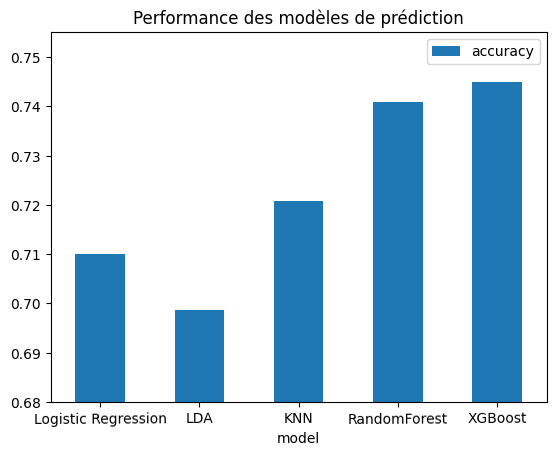

In [67]:
# Visualisation
models.plot(kind='bar', x='model', y='accuracy', ylim=(0.68, 0.755), rot=0.3)
plt.title('Performance des modèles de prédiction')
plt.show()

In [68]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

def compare_roc_curve(classifiers, names):
    for clf, name in zip(classifiers, names):
        try:
            y_scores = cross_val_predict(clf, X_train, y_train, cv=3, method="decision_function")
        except:
            y_probas = cross_val_predict(clf, X_train, y_train, cv=3, method="predict_proba")
            y_scores = y_probas[:, 1] # score = proba of positive class
            
        fpr, tpr, thresholds = roc_curve(y_train, y_scores)
        plot_roc_curve(fpr, tpr, label=name)

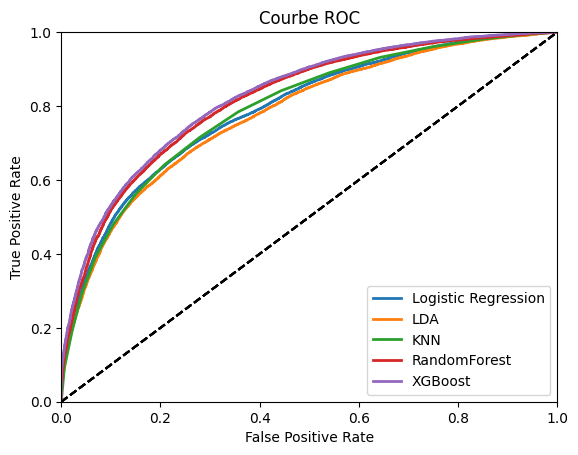

In [69]:
compare_roc_curve([grid_log.best_estimator_, lda, grid_knn.best_estimator_, grid_rf.best_estimator_, grid_xgb.best_estimator_],
                 ["Logistic Regression", "LDA", "KNN", "RandomForest", "XGBoost"])
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

## Final model

Despite the fact that XGBoost does slightly better than RandomForest in terms of accuracy, RandomForest will be the final choice due to its explainability capabilities. In fact, this model gives us a metric for each variable of the training phase; representing their importance in the model performance.

In [70]:
# predictions
predictions = grid_rf.best_estimator_.predict(X_test)

### Matrice de confusion

In [71]:
confusion_matrix(y_test, predictions)

array([[3451, 1296],
       [1117, 3636]])

In [72]:
# Metrics for evaluation
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.76      0.73      0.74      4747
           1       0.74      0.76      0.75      4753

    accuracy                           0.75      9500
   macro avg       0.75      0.75      0.75      9500
weighted avg       0.75      0.75      0.75      9500



## Threshold

In [73]:
y_scores = cross_val_predict(grid_rf.best_estimator_, X_test, y_test, cv=3, method="predict_proba")[:, 1]

In [74]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

In [75]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.grid()

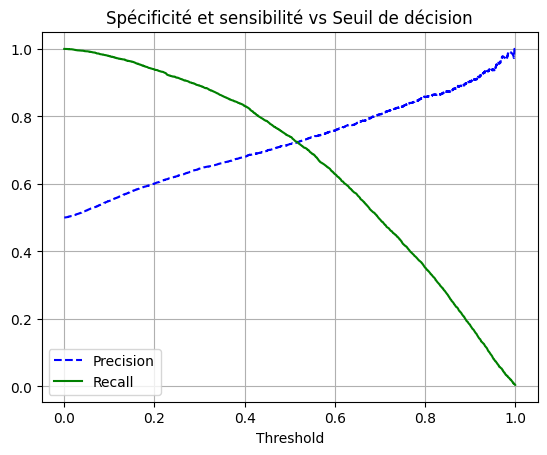

In [76]:
plot_precision_recall_vs_threshold(precision, recall, thresholds)
plt.title('Spécificité et sensibilité vs Seuil de décision')
plt.legend(loc="lower left")
plt.show()

## Features importances

In [77]:
def clean_name(name):
    if name.startswith('num_pipeline__'):
        return name[len('num_pipeline__'):]
    elif name.startswith('cat_pipeline__'):
        return name[len('cat_pipeline__'):]
    return name[len('remainder__'):]

clean = np.vectorize(clean_name)

In [78]:
names = clean(col_trans.get_feature_names_out())

In [79]:
importances = pd.Series(grid_rf.best_estimator_.feature_importances_, index=names)

In [80]:
# Sort feature importances
sorted_importances = importances.sort_values()

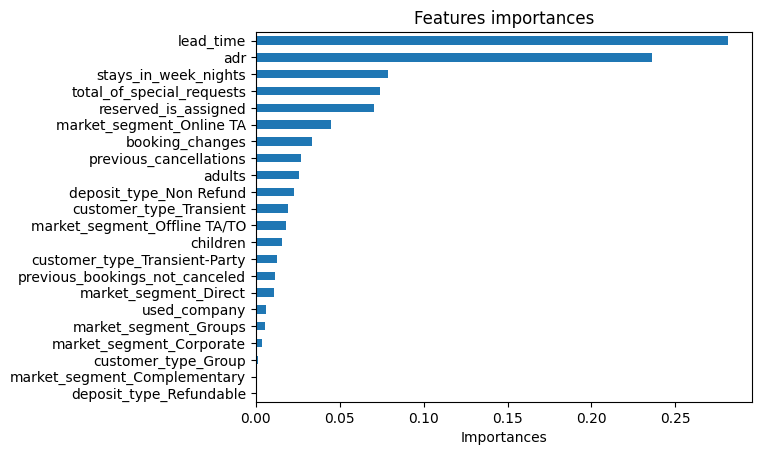

In [81]:
sorted_importances.plot(kind='barh')
plt.xlabel('Importances')
plt.title('Features importances')
plt.show()

In [82]:
clf_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', grid_rf.best_estimator_)
])

In [83]:
# Enregistrement du modèle
with open('../randomForest_v4.pkl', 'wb') as file:
    pickle.dump(clf_pipeline, file)